In [13]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
from scipy import signal
from scipy.interpolate import interp1d
import pickle

In [14]:
func_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_134/func_0/'

In [15]:
# 8 good flies: 116,122,134,154,292,294,296
# out of the 8 flies, there are 4 flies have 3 stimulus patterns(0-180,180-0,middle to lateral)
# and they are 154,292,294, and 296.
# all those flies are with GcAMP6f
# there are good flies with good behavior and neural imaging data but with GcAMP8s
# 153,152,149,143

In [16]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)

### Get Metadata ###
stim_ids, angles = brainsss.get_stimulus_metadata(vision_path)
print(F"Found {len(stim_ids)} presented stimuli.")

# *100 puts in units of 10ms, which will match fictrac
starts_angle = {}
for angle in [0,180]:
    starts_angle[angle] = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times)) if angles[i] == angle]
print(F"starts_angle_0: {len(starts_angle[0])}. starts_angle_180: {len(starts_angle[180])}")

# get 1ms version to match neural timestamps
starts_angle_ms = {}
for angle in [0,180]:
    starts_angle_ms[angle] = [i*10 for i in starts_angle[angle]]

loading photodiode data... done
Loaded from Pickle.
Found 753 presented stimuli.
starts_angle_0: 374. starts_angle_180: 374


In [4]:
np.diff(stimulus_start_times[:10])

array([61.2805,  2.0418,  2.0419,  2.0418,  2.0419,  2.0501,  2.0336,
        2.0418,  2.0419])

In [7]:
# def get_stimulus_metadata(vision_path, printlog=None):
#     # if this function is not being used with a printlog, redirect printlog to simply print
#     if printlog is None:
#         printlog = print

#     ### try to get from pickle ###
# #     pickle_path = os.path.join(vision_path, 'stimulus_metadata.pkl')
# #     if os.path.exists(pickle_path):
# #         printlog("Loaded from Pickle.")
# #         with open(pickle_path, 'rb') as f:
# #             metadata = pickle.load(f)
# #         return metadata['stim_ids'], metadata['angles']

#     ### if no pickle, load from .h5 and save pickle for future ###
#     printlog("No pickle; parsing visprotocol.h5")
#     fname = [x for x in os.listdir(vision_path) if '.hdf5' in x][0]
#     visprotocol_file = os.path.join(vision_path, fname)

#     with h5py.File(visprotocol_file, 'r') as file:

#         try:
#             ## if no key error it must be a visprotocol metadata file ##
#             print('visprotocol')
#             fly_ids = file['Flies']
#             metadata = brainsss.parse_visprotocol_metadata(file)
#         except KeyError:
#             print('other')
#             ## if keyerror it is a visual_stimulation metadata file ##
#             metadata = brainsss.parse_visual_stimulation_metadata(file)

#         ### SAVE ###
#         if metadata is not None:
#             save_file = os.path.join(vision_path, 'stimulus_metadata.pkl')
#             with open(save_file, 'wb') as f:
#                 pickle.dump(metadata, f)
#             printlog("created {}".format(save_file))
#         else:
#             printlog("did not find any series longer than 100 stimuli. Not saving metadata pickle.")

#         return metadata['stim_ids'], metadata['angles']
#         printlog('Could not get visual metadata.')


In [17]:
#stim_ids, angles = get_stimulus_metadata(vision_path)

In [12]:
#os.listdir(vision_path)

In [ ]:
#starts_angle_ms

In [11]:
#stim_ids

In [10]:
#angles

In [18]:
####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
fictrac_timestamps = np.arange(0,expt_len,resolution)

In [19]:
###########################################
### Extract Stimulus Triggered Behavior ###
###########################################

pre_window = 200
post_window = 300

behavior_traces = {}
mean_trace = {}
sem_trace = {}
for angle in [0,180]:
    behavior_traces[angle],mean_trace[angle],sem_trace[angle] = brainsss.extract_traces(fictrac,
                                                                                        starts_angle[angle],
                                                                                        pre_window,
                                                                                        post_window)

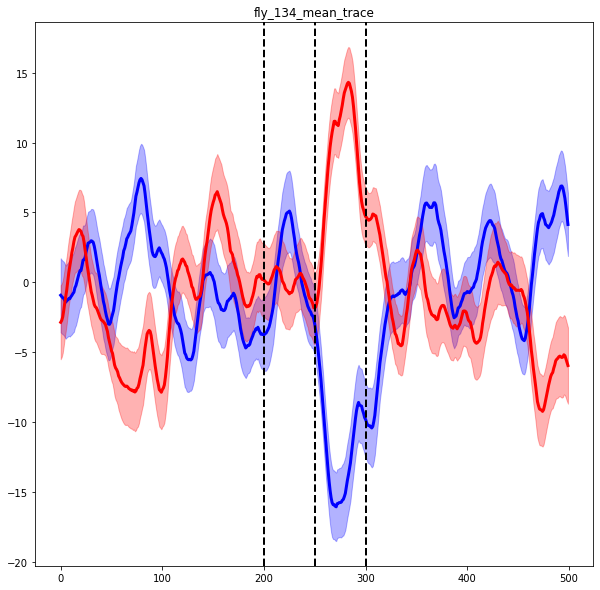

In [26]:
plt.figure(figsize=(10,10))

for angle,color in zip([0,180],['blue','red']):
    plt.plot(mean_trace[angle],color=color,linewidth=3)
    plt.fill_between(np.arange(len(mean_trace[angle])),mean_trace[angle]-sem_trace[angle], mean_trace[angle]+sem_trace[angle], color=color,alpha=0.3)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
plt.title(F'fly_134_mean_trace')

save_path = '/oak/stanford/groups/trc/data/yandan/2P_Imaging/optomotor_response_analysis'
save_file = os.path.join(save_path,"figs",'fly_134_mean_trace')
plt.savefig(save_file,dpi=300,bbox_inches="tight",transparent=False)
            

In [23]:
stim_start = 250
stim_stop = 300
av_thresh = 50

mean_turn = (mean_trace[0] + mean_trace[180]*-1)/2

ve_turns = {}
ve_turn_times = {}
for angle,direction in zip([0,180],['neg','pos']):
    ve_turns[angle], ve_turn_times[angle] = brainsss.get_visually_evoked_turns(behavior_traces[angle],
                                                                      mean_turn = mean_turn,
                                                                      start=stim_start, 
                                                                      stop=stim_stop, 
                                                                      r_thresh=.2, 
                                                                      av_thresh=av_thresh, 
                                                                      stim_times=starts_angle_ms[angle],
                                                                      expected_direction=direction)

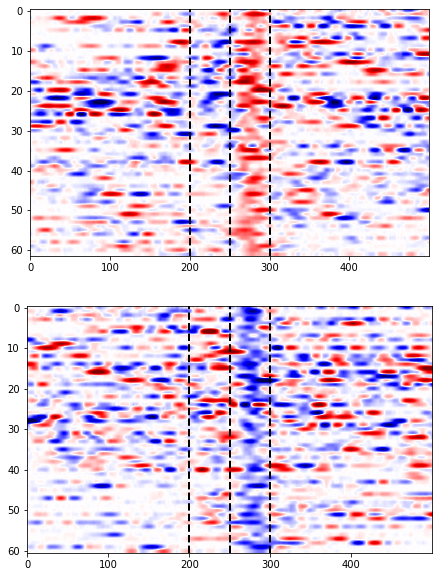

In [24]:
fig = plt.figure(figsize=(10,10))

plt.subplot(211)
plt.imshow(ve_turns[180],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.subplot(212)
plt.imshow(ve_turns[0],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)

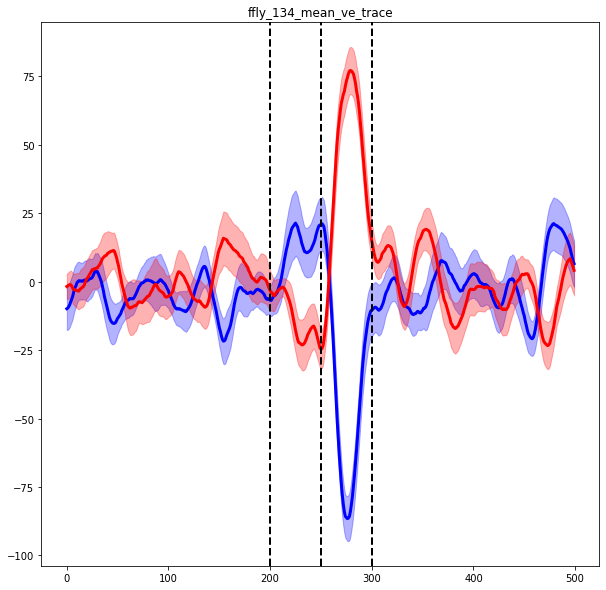

In [28]:
plt.figure(figsize=(10,10))

for angle,color in zip([0,180],['blue','red']):
    mean_ve_trace = np.mean(ve_turns[angle],axis=0)
    sem_ve_trace = scipy.stats.sem(ve_turns[angle],axis=0)
    
    plt.plot(mean_ve_trace,color=color,linewidth=3)
    plt.fill_between(np.arange(len(mean_ve_trace)),mean_ve_trace-sem_ve_trace, mean_ve_trace+sem_ve_trace, color=color,alpha=0.3)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)

plt.title(F'ffly_134_mean_ve_trace')
save_path = '/oak/stanford/groups/trc/data/yandan/2P_Imaging/optomotor_response_analysis'
save_file = os.path.join(save_path,"figs",'fly_134_mean_ve_trace')
plt.savefig(save_file,dpi=300,bbox_inches="tight",transparent=False)

In [29]:
def get_stimuli_where_no_behavior(traces, start, stop, num_traces_to_return, stim_times):
    amount_of_behavior = np.mean(np.abs(traces[:,start:stop]),axis=-1)
    indicies = np.argsort(amount_of_behavior)
    top_x_indicies = indicies[:num_traces_to_return]
    return traces[top_x_indicies,:], np.asarray(stim_times)[top_x_indicies]

In [30]:
ve_no_turns = {}
ve_no_turn_times = {}
for angle in [0,180]:
    ve_no_turns[angle], ve_no_turn_times[angle] = get_stimuli_where_no_behavior(behavior_traces[angle],
                                  start=250,
                                  stop=300,
                                  num_traces_to_return=len(ve_turns[angle]), # get the same number as ve_turns
                                  stim_times=starts_angle_ms[angle])

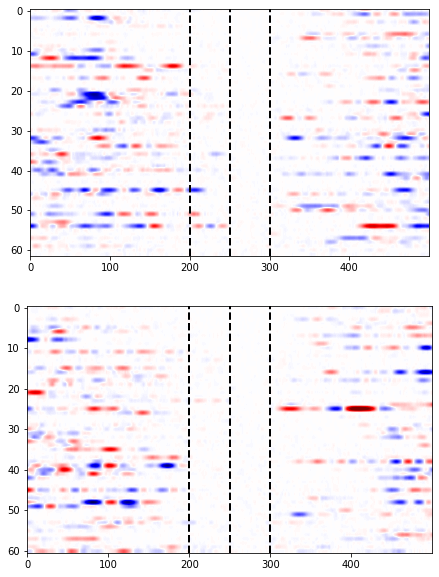

In [31]:
fig = plt.figure(figsize=(10,10))

plt.subplot(211)
plt.imshow(ve_no_turns[180],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.subplot(212)
plt.imshow(ve_no_turns[0],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)

(-50.0, 50.0)

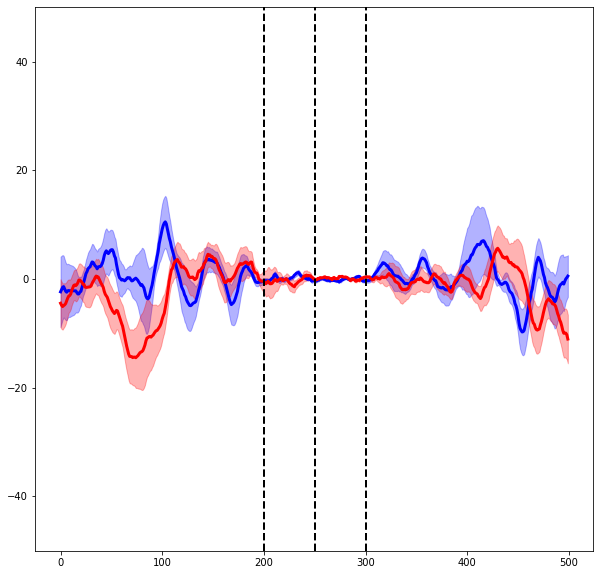

In [32]:
plt.figure(figsize=(10,10))

for angle,color in zip([0,180],['blue','red']):
    mean_ve_trace = np.mean(ve_no_turns[angle],axis=0)
    sem_ve_trace = scipy.stats.sem(ve_no_turns[angle],axis=0)
    
    plt.plot(mean_ve_trace,color=color,linewidth=3)
    plt.fill_between(np.arange(len(mean_ve_trace)),mean_ve_trace-sem_ve_trace, mean_ve_trace+sem_ve_trace, color=color,alpha=0.3)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.ylim(-50,50)

# load neural

In [33]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'clustering')

load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
all_signals = np.load(load_file)

# extract grey baseline

In [34]:
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))

Trying to load timestamp data from hdf5 file.
Success.


In [35]:
##########################
### GET WALKING VECTOR ###
##########################

y_std = fictrac['Y']/np.std(fictrac['Y'])
z_std = fictrac['Z']/np.std(fictrac['Z'])
movement = (y_std**2 + z_std**2)**0.5
movement = scipy.ndimage.filters.gaussian_filter(movement,sigma=10)
walking = np.zeros(len(movement))
walking[np.where(movement>0.2)] = 1

In [36]:
######################
### GET GREY TIMES ###
######################

grey_starts = []
grey_stops = []
for i,stim in enumerate(stim_ids):
    if stim == 'ConstantBackground':
        grey_starts.append(stimulus_start_times[i])
        grey_stops.append(stimulus_start_times[i]+60)
grey_starts = [i*1000 for i in grey_starts] #s to ms
grey_stops = [i*1000 for i in grey_stops] #s to ms

grey_periods = np.zeros(len(walking))
for i in range(len(grey_starts)):
    grey_periods[np.where((grey_starts[i] < fictrac_timestamps) & (fictrac_timestamps < grey_stops[i]))[0]] = 1

In [37]:
grey_starts

[1309.1999999999998, 444198.8, 887138.4, 1329944.7, 1772859.3]

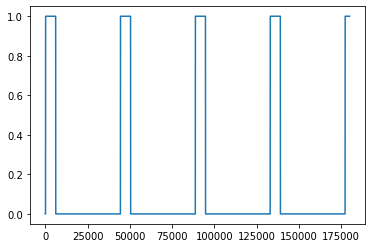

In [38]:
plt.plot(grey_periods)

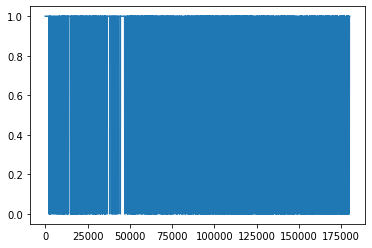

In [39]:
plt.plot(walking)

In [40]:
np.sum(walking==0), np.sum(walking==1)

(57311, 122689)

In [41]:
slice_avgs = []
for z in range(49):
    idx = np.ndarray.astype(timestamps[:,z]/10,'int')[:-1] # remove last idx because it could go over 1800s
    grey_and_stopped = np.logical_and(walking[idx] == 0, grey_periods[idx]==1)
    grey_and_walking = np.logical_and(walking[idx] == 1, grey_periods[idx]==1)
    grey_and_stopped = np.append(grey_and_stopped, False)
    slice_avgs.append(np.mean(all_signals[z,:,grey_and_stopped],axis=0))
baseline_brain = np.asarray(slice_avgs)
baseline_brain.shape

(49, 2000)

##### visualize baseline

In [42]:
test = brainsss.STA_supervoxel_to_full_res(baseline_brain[:,np.newaxis,:], cluster_labels)

In [44]:
fixed = brainsss.load_fda_meanbrain()

In [45]:
warp = brainsss.warp_STA_brain(STA_brain=test, fly='fly_134', fixed=fixed, anat_to_mean_type='myr')

In [50]:
input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
data_to_plot = warp[0][:,:,::-1]
vmax = 0.5
explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                    roi_masks,
                                                    roi_contours,
                                                    data_to_plot,
                                                    input_canvas,
                                                    vmax=vmax,
                                                    cmap='seismic',
                                                    diverging=True)

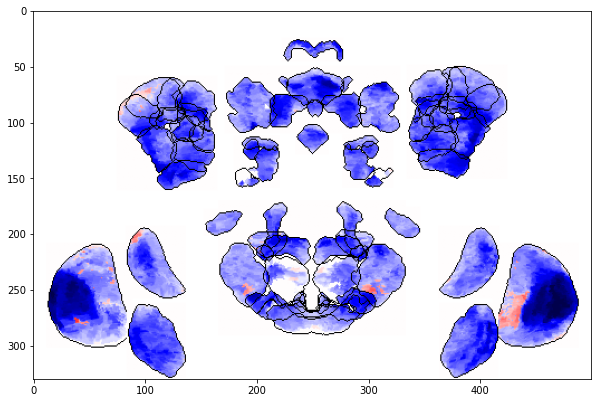

In [51]:
plt.figure(figsize=(10,10))
plt.imshow(explosion_map[170:,:])

# make STA and explode

In [47]:
fixed = brainsss.load_fda_meanbrain()

In [48]:
atlas = brainsss.load_roi_atlas()

In [49]:
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [52]:
bin_start = -1100; bin_end = 2000; bin_size = 100
neural_bins = np.arange(bin_start,bin_end,bin_size)

In [53]:
### Create Notch Filter ###

fs = 50.0  # Sample frequency (Hz)
f0 = 1.8797  # Frequency to be removed from signal (Hz)
Q = 0.2  # Quality factor <---- IMPORTANT # the bigger this number the wider the notch
w0 = f0/(fs/2)  # Normalized Frequency

# Design notch filter
b_notch, a_notch = signal.iirnotch(w0, Q)

# Frequency response

w, h = signal.freqz(b_notch, a_notch)

# Generate frequency axis
freq = w*fs/(2*np.pi)

In [54]:
all_warps = {}
for condition in ['ve_no_0','ve_no_180','ve_0','ve_180']:
    print(condition)
    
    if '180' in condition:
        angle = 180
    else:
        angle = 0
    if 'no' in condition:
        event_times_list = ve_no_turn_times[angle]
    else:
        event_times_list = ve_turn_times[angle]
    
    t0 = time.time()
    STA_brain = brainsss.make_STA_brain(neural_signals = all_signals,
                                       neural_timestamps = timestamps,
                                       event_times_list = event_times_list,
                                       neural_bins = neural_bins)
    print(F'STA {time.time()-t0}')

    STA_brain -= baseline_brain[:,np.newaxis,:]
    #break
    ### FOR TESTING 50HZ NOTCH
    #STA_brain_interp_temp = interp1d(np.arange(0,3000,100), STA_brain, bounds_error = False, axis=1)
    #STA_brain_interp = STA_brain_interp_temp(np.arange(0,3000,20))
    #STA_brain = signal.filtfilt(b_notch, a_notch, STA_brain_interp, axis=1)
    reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels)
    #STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)
    STA_brain=reformed_STA_brain
    
    t0 = time.time()
    warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_134', fixed=fixed, anat_to_mean_type='myr')
    all_warps[condition] = np.asarray(warps)
    print(F'Warps {time.time()-t0}')

ve_no_0
STA 1.263042688369751
Warps 18.65892457962036
ve_no_180
STA 1.1825382709503174
Warps 18.146836519241333
ve_0
STA 1.3576300144195557
Warps 17.11703133583069
ve_180
STA 1.291757345199585
Warps 16.991466760635376


In [55]:
STA_brain.shape

(49, 30, 256, 128)

In [58]:
plt.plot(STA_brain[20,:,1000])

IndexError: index 1000 is out of bounds for axis 2 with size 256

In [59]:
all_warps['ve_0'].shape

(30, 314, 146, 91)

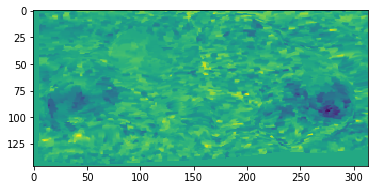

In [60]:
plt.imshow(all_warps['ve_0'][10,:,:,30].T)

In [56]:
#STA_brain will be (z,tp,v)
#want to upsample to 50Hz to test exact same notch filter as paper
STA_brain_interp_temp = interp1d(np.arange(0,3000,100), STA_brain, bounds_error = False, axis=1)
STA_brain_interp = STA_brain_interp_temp(np.arange(0,3000,20))

In [57]:
len(neural_bins)

31

In [58]:
STA_brain_interp.shape

(49, 150, 256, 128)

In [59]:
len(all_warps)

4

In [68]:
all_explosions = {}
for condition in ['ve_no_0','ve_no_180','ve_0','ve_180']:
    print(condition)
    explosions = []
    t0 = time.time()
    for tp in range(24):
        input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
        data_to_plot = all_warps[condition][tp][:,:,::-1]
        vmax = 1#0.5
        explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='seismic',
                                                            diverging=True)#'hot')
        explosions.append(explosion_map)
    print(F'Explosion {time.time()-t0}')
    all_explosions[condition] = explosions

ve_no_0
Explosion 24.73289465904236
ve_no_180
Explosion 24.546484231948853
ve_0
Explosion 24.79388451576233
ve_180
Explosion 24.807719945907593


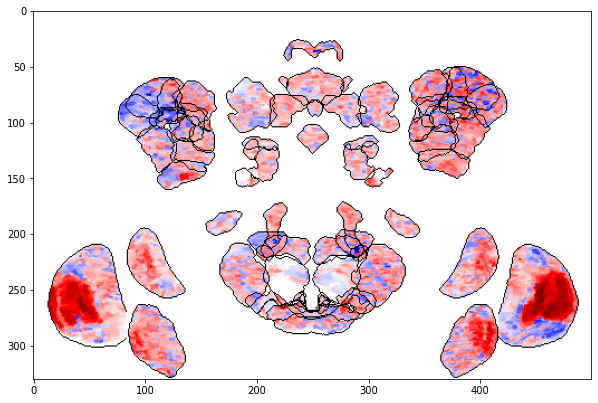

In [81]:
plt.figure(figsize=(10,10))
plt.imshow(all_explosions['ve_no_0'][15][170:,:])

In [71]:
def plot_panel(condition, tp, plt_num):
    plt.subplot(2,2,plt_num)
    plt.imshow(all_explosions[condition][tp][170:,:])
    plt.title(condition,color='k',y=.93,fontsize=12)
    plt.axis('off')

In [66]:
# for tp in range(len(neural_bins)-1):
#     print(tp)
#     fig = plt.figure(figsize=(14.8,10))

#     plot_panel('ve_no_0', tp, 1)
#     plt.text(5,30,'Time: {}ms'.format(neural_bins[tp]),fontsize=14,color='k')
#     plot_panel('ve_no_180', tp, 2)
#     plot_panel('ve_0', tp, 3)
#     plot_panel('ve_180', tp, 4)
#     plt.subplots_adjust(hspace=0,wspace=0)
#     plt.suptitle('fly_134',y=.9)

#     save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/movies/fly134_movie'
#     if not os.path.exists(save_path):
#         os.mkdir(save_path)
#     fname = os.path.join(save_path, '{0:05d}.png'.format(tp))
#     plt.savefig(fname,dpi=300,bbox_inches='tight')
#     plt.close()

-500

Text(0.5, 0.9, 'fly_134')

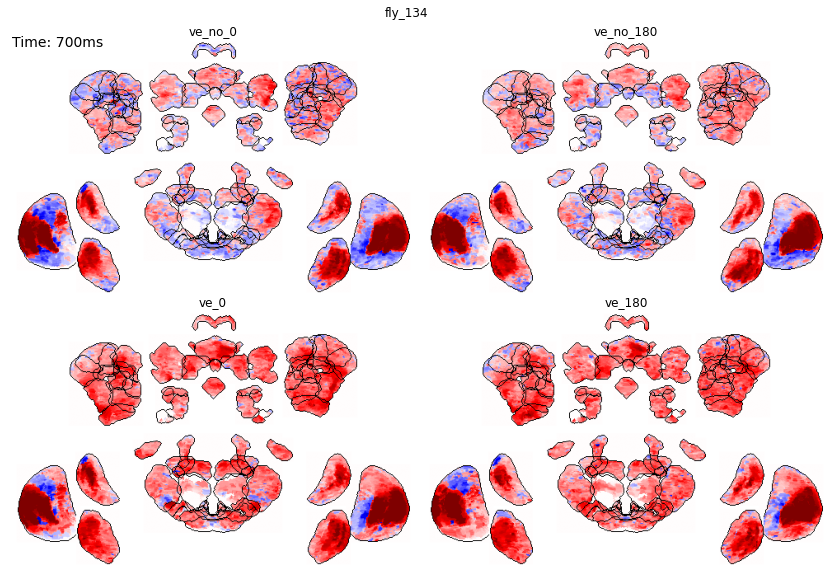

In [84]:
tp = 18

fig = plt.figure(figsize=(14.8,10))

plot_panel('ve_no_0', tp, 1)
plt.text(5,30,'Time: {}ms'.format(neural_bins[tp]),fontsize=14,color='k')
plot_panel('ve_no_180', tp, 2)
plot_panel('ve_0', tp, 3)
plot_panel('ve_180', tp, 4)
plt.subplots_adjust(hspace=0,wspace=0)
plt.suptitle('fly_134',y=.9)

# make temporal traces of ROIs

In [72]:
roi_ids, names = brainsss.load_roi_hemi_ids()

In [73]:
fs = 50.0  # Sample frequency (Hz)
f0 = 1.8797  # Frequency to be removed from signal (Hz)
Q = .8  # Quality factor <---- IMPORTANT
w0 = f0/(fs/2)  # Normalized Frequency
# Design notch filter
b_notch, a_notch = signal.iirnotch(w0, Q)

roi_signal = {}
for signal_type in ['mean']:#['max', 'mean']:
    roi_signal[signal_type] = {}
    for hemi in ['right', 'left']:
        roi_signal[signal_type][hemi] = {}
        for condition in ['ve_0','ve_180','ve_no_0','ve_no_180']:
            ROI_TRACE = brainsss.extract_roi_signal_traces(roi_ids,
                                                            roi_masks,
                                                            all_warps,
                                                            condition,
                                                            hemi,
                                                            signal_type)
            ### FOR TESTING 50HZ NOTCH
            ROI_TRACE_interp_temp = interp1d(np.arange(0,3000,100), ROI_TRACE, bounds_error = False, axis=1, fill_value='extrapolate')
            ROI_TRACE_interp = ROI_TRACE_interp_temp(np.arange(0,3000,20))
            ROI_TRACE_filtered = signal.filtfilt(b_notch, a_notch, ROI_TRACE_interp, axis=1)
            roi_signal[signal_type][hemi][condition] = ROI_TRACE_filtered

16.45384454727173
16.60806155204773
16.459308385849
16.5689480304718
16.403419733047485
16.504333019256592
16.41868305206299
16.47504425048828


In [277]:
# fs = 50.0  # Sample frequency (Hz)
# f0 = 1.8797  # Frequency to be removed from signal (Hz)
# Q = .2  # Quality factor <---- IMPORTANT
# w0 = f0/(fs/2)  # Normalized Frequency
# # Design notch filter
# b_notch, a_notch = signal.iirnotch(w0, Q)

# ROI_TRACE_interp_temp = interp1d(np.arange(0,3000,100), ROI_TRACE, bounds_error = False, axis=1)
# ROI_TRACE_interp = ROI_TRACE_interp_temp(np.arange(0,3000,20))
# ROI_TRACE_filtered = signal.filtfilt(b_notch, a_notch, ROI_TRACE_interp,axis=1)

(39, 30)


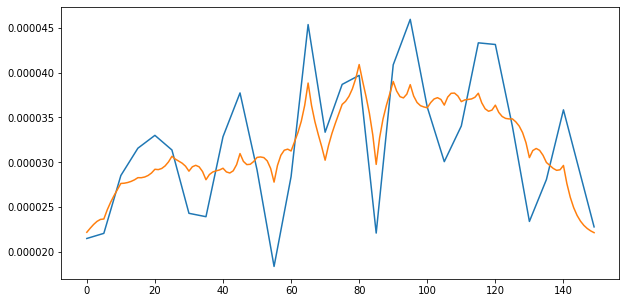

In [328]:
# data = ROI_TRACE.copy()
# print(data.shape)

# data_interp_temp = interp1d(np.arange(0,3000,100), data, bounds_error = False, axis=1, fill_value='extrapolate')
# data_interp = data_interp_temp(np.arange(0,3000,20))
# #ROI_TRACE_filtered = signal.filtfilt(b_notch, a_notch, ROI_TRACE_interp,axis=1)

# fs = 50.0  # Sample frequency (Hz)
# f0 = 1.8797  # Frequency to be removed from signal (Hz)
# Q = .8  # Quality factor <---- IMPORTANT
# w0 = f0/(fs/2)  # Normalized Frequency
# # Design notch filter
# b_notch, a_notch = signal.iirnotch(w0, Q)

# out = signal.filtfilt(b_notch, a_notch, data_interp, axis=1)

# plt.figure(figsize=(10,5))
# plt.plot(data_interp[9,:])
# plt.plot(out[9,:])

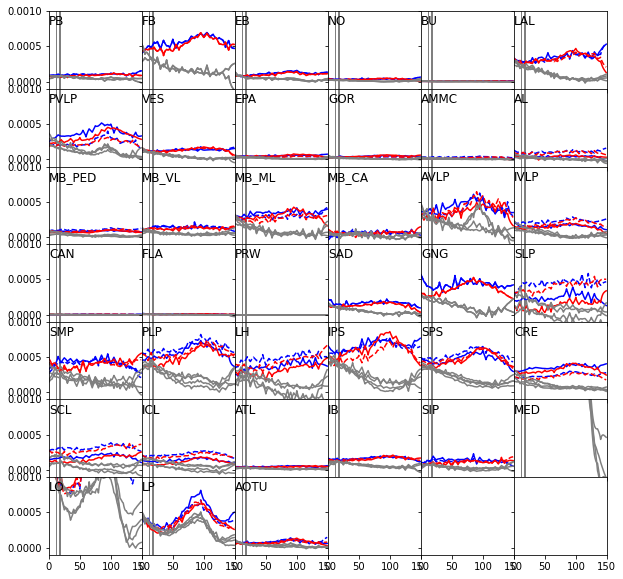

In [85]:
#full_left_group and STA_in_atlas_space_left should indeed both refer to the left brain

#right turn is blue, left turn is red
#solid line is left brain, dashed line is right brain

#so the general hypothesis is for solid lines the red should be higher, and for dashed line the blue should be higher
signal_type = 'mean'

#for max view we want x zoom in
if signal_type == 'max':
    roi_y_coor = .8
    roi_x_coor = 9
    vertical_lines = [11,16,18]
    x_start = 0#8
    x_end = 50#25
    y_start = 0
    y_end = 1
if signal_type == 'mean':
    roi_y_coor = 0.0008
    roi_x_coor = .2
    vertical_lines = [11,16,18]#[3,8,10]
    x_start = 0
    x_end = 150
    y_start = -0.0001
    y_end = 0.001

fig, ax = plt.subplots(7, 6, sharex='col', sharey='row', figsize=(10,10))
pltnum = 0
for i in range(7):
    for j in range(6):
        if pltnum == 39:
            break
        
        for line in vertical_lines:
            ax[i,j].axvline(line,linestyle='-',color='k',linewidth=.5)
        
        ax[i,j].plot(roi_signal[signal_type]['left']['ve_0'][pltnum,:],color='blue',linestyle='-')
        ax[i,j].plot(roi_signal[signal_type]['right']['ve_0'][pltnum,:],color='blue',linestyle='--')
        ax[i,j].plot(roi_signal[signal_type]['left']['ve_180'][pltnum,:],color='red',linestyle='-')
        ax[i,j].plot(roi_signal[signal_type]['right']['ve_180'][pltnum,:],color='red',linestyle='--')
        
        ax[i,j].plot(roi_signal[signal_type]['left']['ve_no_0'][pltnum,:],color='grey',linestyle='-')
        ax[i,j].plot(roi_signal[signal_type]['right']['ve_no_0'][pltnum,:],color='grey',linestyle='-')
        ax[i,j].plot(roi_signal[signal_type]['left']['ve_no_180'][pltnum,:],color='grey',linestyle='-')
        ax[i,j].plot(roi_signal[signal_type]['right']['ve_no_180'][pltnum,:],color='grey',linestyle='-')
        
        ax[i,j].text(roi_x_coor, roi_y_coor, names[pltnum],fontsize=12)
        ax[i,j].set_ylim(y_start,y_end)
        ax[i,j].set_xlim(x_start,x_end)
        
        pltnum += 1

plt.subplots_adjust(hspace=0,wspace=0)
#plt.suptitle(f'{fly}, {signal_type} voxel value per ROI',y=.9)

save_path = '/oak/stanford/groups/trc/data/yandan/2P_Imaging/optomotor_response_analysis/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')


In [77]:
len(roi_signal['mean']['left']['ve_0'][0,:])

150

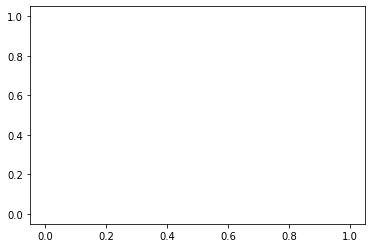

In [211]:
plt.plot(roi_signal['mean']['left']['ve_0'][1,:])

# hemi subtract version

In [91]:
def extract_roi_signal_traces(roi_ids, roi_masks, all_warps, condition, hemi, signal_type):
    t0 = time.time()
    roi_time_avgs = []
    for roi in roi_ids[hemi]:
        mask = roi_masks[roi]
        #print(mask.shape)
        mask = mask[:157,:,:]
        masked_data = all_warps[:,:,:,::-1]*mask[np.newaxis,:,:,:] #note z-flip
        if signal_type == 'max':
            roi_time_avg = np.max(masked_data,axis=(1,2,3))
        elif signal_type == 'mean':
            roi_time_avg = np.mean(masked_data,axis=(1,2,3))
        roi_time_avgs.append(roi_time_avg)
    print(time.time()-t0)
    return np.asarray(roi_time_avgs)

roi_signal = {}
for signal_type in ['mean']:#['max', 'mean']:
    roi_signal[signal_type] = {}
    for hemi in ['left']:
        roi_signal[signal_type][hemi] = {}
        for condition in ['ve_0','ve_180','ve_no_0','ve_no_180']:
            data = all_warps[condition][:,:157,:,:]-all_warps[condition][:,-157:,:,:][:,::-1,:,:]
            roi_signal[signal_type][hemi][condition] = extract_roi_signal_traces(roi_ids,
                                                                                roi_masks,
                                                                                data,
                                                                                condition,
                                                                                hemi,
                                                                                signal_type)

5.7327868938446045
5.633984804153442
5.479677438735962
5.539537191390991


In [92]:
### masks go from A to P (opposite of imaging)
# that is why I flip the z axis of the imaging
# this flip will flip the hemis...
# for the difference I subtract the right from the left but the subsequent z flip does nothing since one hemi
# so for this diff, positive values mean left hemi is higher

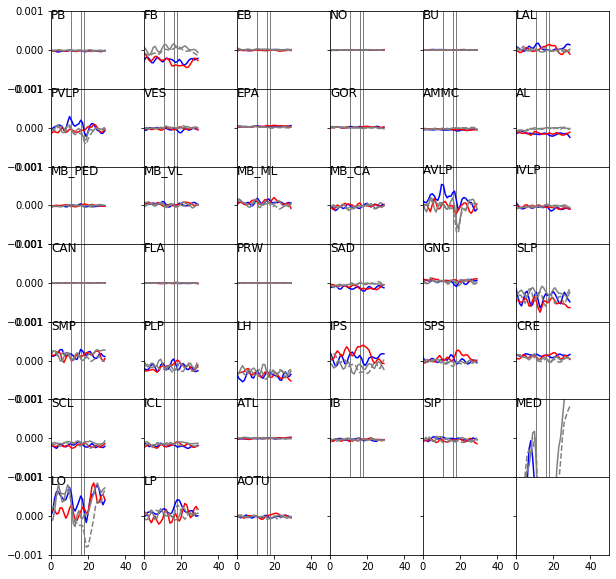

In [98]:
#full_left_group and STA_in_atlas_space_left should indeed both refer to the left brain

#right turn is blue, left turn is red
#solid line is left brain, dashed line is right brain

#so the general hypothesis is for solid lines the red should be higher, and for dashed line the blue should be higher
signal_type = 'mean'

#for max view we want x zoom in
if signal_type == 'max':
    roi_y_coor = .8
    roi_x_coor = 9
    vertical_lines = [11,16,18]
    x_start = 0#8
    x_end = 50#25
    y_start = 0
    y_end = 1
if signal_type == 'mean':
    roi_y_coor = 0.0008
    roi_x_coor = .2
    vertical_lines = [11,16,18]#[3,8,10]
    x_start = 0
    x_end = 50
    y_start = -0.001
    y_end = 0.001

fig, ax = plt.subplots(7, 6, sharex='col', sharey='row', figsize=(10,10))
pltnum = 0
for i in range(7):
    for j in range(6):
        if pltnum == 39:
            break
        
        for line in vertical_lines:
            ax[i,j].axvline(line,linestyle='-',color='k',linewidth=.5)
        
        ax[i,j].plot(roi_signal[signal_type]['left']['ve_0'][pltnum,:],color='blue',linestyle='-')
        #ax[i,j].plot(roi_signal[signal_type]['right']['ve_0'][pltnum,:],color='blue',linestyle='--')
        ax[i,j].plot(roi_signal[signal_type]['left']['ve_180'][pltnum,:],color='red',linestyle='-')
        #ax[i,j].plot(roi_signal[signal_type]['right']['ve_180'][pltnum,:],color='red',linestyle='--')
        
        ax[i,j].plot(roi_signal[signal_type]['left']['ve_no_0'][pltnum,:],color='grey',linestyle='--')
        #ax[i,j].plot(roi_signal[signal_type]['right']['ve_no_0'][pltnum,:],color='grey',linestyle='-')
        ax[i,j].plot(roi_signal[signal_type]['left']['ve_no_180'][pltnum,:],color='grey',linestyle='-')
        #ax[i,j].plot(roi_signal[signal_type]['right']['ve_no_180'][pltnum,:],color='grey',linestyle='-')
        
        ax[i,j].text(roi_x_coor, roi_y_coor, names[pltnum],fontsize=12)
        ax[i,j].set_ylim(y_start,y_end)
        ax[i,j].set_xlim(x_start,x_end)
        
        pltnum += 1

plt.subplots_adjust(hspace=0,wspace=0)
#plt.suptitle(f'{fly}, {signal_type} voxel value per ROI',y=.9)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')


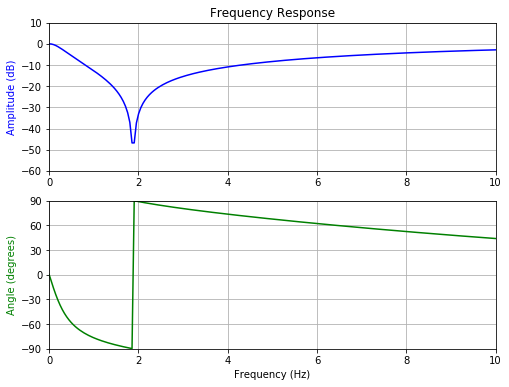

In [248]:
fs = 50.0  # Sample frequency (Hz)
f0 = 1.8797  # Frequency to be removed from signal (Hz)
Q = .2  # Quality factor
# Design notch filter
b, a = signal.iirnotch(f0, Q, fs)

# Frequency response
freq, h = signal.freqz(b, a, fs=fs)
# Plot
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].set_xlim([0, 10])
ax[0].set_ylim([-60, 10])
ax[0].grid(True)
ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Angle (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim([0, 10])
ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax[1].set_ylim([-90, 90])
ax[1].grid(True)
plt.show()

In [182]:
os.mkdir('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221029_FDA_direct_affine_DSX/murthy')